In [1]:
#%matplotlib notebook
#%matplotlib auto

from scipy import stats
import galpy.potential
from galpy.orbit import Orbit
from astropy import units as u
from galpy.potential import LogarithmicHaloPotential
import numpy as np
from galpy.potential import MWPotential2014,PowerSphericalPotential
#from galpy.potential import FerrersPotential,DehnenBarPotential
import matplotlib.pyplot as plt
#import gala.integrate as gi
#import gala.dynamics as gd
#import gala.potential as gp
#from gala.units import galactic
import astropy.units as u
from orbit_functions import *
import pickle
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from scipy.ndimage import gaussian_filter
from galpy.potential import plotRotcurve
from functools import partial
from scipy.fft import *
from scipy import interpolate, optimize
from astropy.io import fits
from astropy.table import Table

plt.rcParams['font.size'] = 12

In [2]:
class Loader():
    o_cache = None
    o_cache_name = None
    oo = None

    def load_model(self, model, time, xmin=1000, xmax=3000, phi_range=0.2, maxvr=20):
        
        if model == 'MW_Sgr':
            Rmax=16.
            snap=str(int(np.round(time*100))) if time>=1 else '0'+str(int(time*100))
            df = Table.read('MW_Sgr/disk'+snap+'.fits', format='fits').to_pandas()
            df['X'],df['Y'],df['Z'],df['VX'],df['VY'],df['VZ']=cyl2cart(df['R'],df['phi'],df['Z'],df['VR'],df['Vphi'],df['VZ'])
            ind=df['R']<Rmax
            df=df[ind]    
            x,y,z,VR,Vphi,VZ,R,phi=df['X'],df['Y'],df['Z'],df['VR'],df['Vphi'],df['VZ'],df['R'],df['phi']
            Vphi=Vphi*-1.
            Lz=R*Vphi
        else:
            if self.o_cache_name == model:
                o = self.o_cache
            else:
                file='o_galpy/o_'+model+'.pkl'
                with open(file, 'rb') as f:#for orbits after perturbation
                    o = pickle.load(f)
                self.o_cache = o
                self.o_cache_name = model

            t=time*u.Gyr
            x=o.x(t)
            y=-o.y(t)#in galpy, orbits turn counterclockwise. changing sign of y we turn it into clockwise
            VR=o.vr(t)
            Vphi=o.vphi(t)*o.r(t)
            R=o.r(t)
            Lz=R*Vphi
            phi=o.phi(t)

        indphi=(np.abs(phi)>np.pi-phi_range)&(np.abs(phi)<np.pi+phi_range)
        x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
        indphi=(np.abs(VR)<maxvr)&(Lz>xmin)&(Lz<xmax)
        x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
        DATA = False
        
        return x,y,VR,Vphi,R,Lz,phi

    def load_data(self, xmin=1500, xmax=3500, phi_range=0.4):
        if self.oo == None:
            path = 'o_galpy/SoS_SH_Gaia_test_GAL6D.fits'
            self.oo = Table.read(path, format='fits')
        oo = self.oo

        VR,Vphi,VZ,x,y,Z,R,phi=np.array((oo['VR'],oo['Vphi'],oo['VZ'],oo['X'],oo['Y'],oo['Z'],oo['R'],oo['phi']))
        Lz=-oo['Vphi']*oo['R']
        phi=-np.deg2rad(phi)
        Vphi=-Vphi
        
        indphi = abs(phi) < phi_range
        x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
        indphi=(Lz>xmin)&(Lz<xmax)
        x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
        
        DATA = True
        return x,y,VR,Vphi,R,Lz,phi

def smooth_bins(x, y, xmin, xmax, binsize):
    binsLZ=np.arange(xmin,xmax,binsize)
    m,xedge,binnumber=stats.binned_statistic(x, y, statistic='mean', bins=[binsLZ]) 
    nx = np.arange(xmin-binsize/2, xmax, binsize)
    xpol = nx + binsize/2
    means = []
    for k in nx:
        rel = y[(k<x) & (x<k+binsize)]
        if len(rel) == 0:
            means.append(means[-1])
        else:
            means.append(np.mean(rel))
    ypol = np.array(means)
    return xpol, ypol

l = Loader()

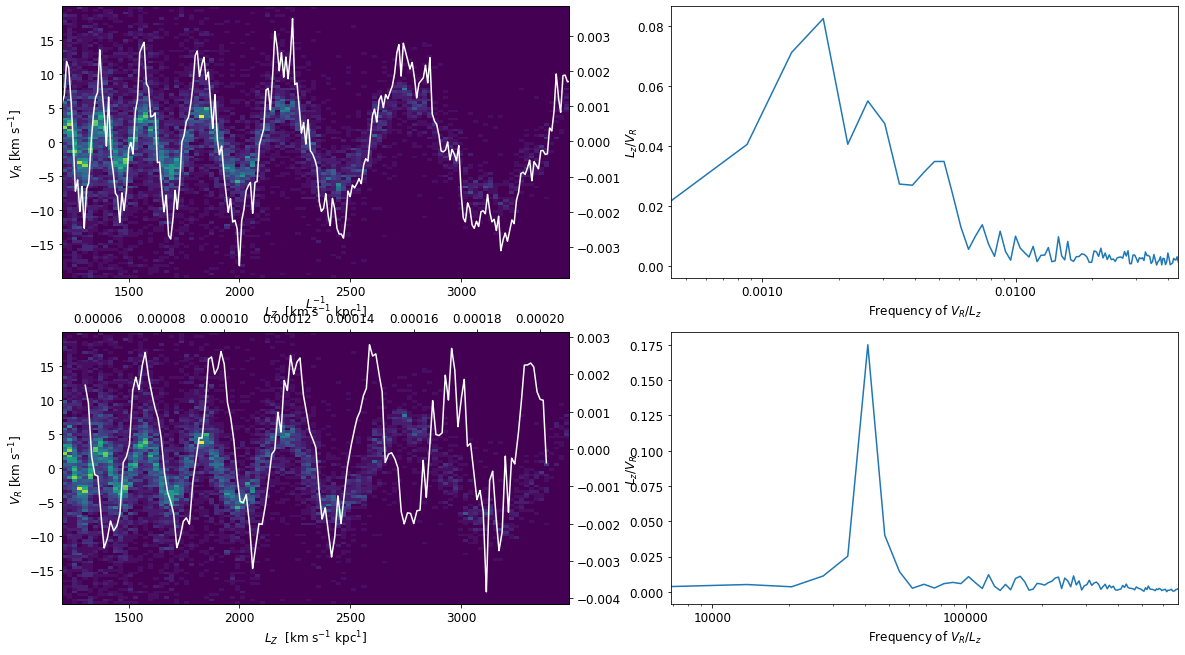

In [3]:
TIME = 2.0
XMIN=1200
XMAX=3500
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_model('Dhot_log', TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2)
DATA = False

fig, ax = plt.subplots(2,2,figsize=(20,11))

nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
N = 100000
#f = interpolate.interp1d(nx, ny, kind='linear')
#xpol = np.linspace(nx[0], nx[-1], N)
#ypol = f(xpol)
ax[0][0].hist2d(Lz, VR, bins=100);
ax[0][0].set_aspect('auto')
ax[0][0].set_xlabel(r'$L_Z$  [km s$^{-1}$ kpc$^{1}$]')
ax[0][0].set_ylabel(r'$V_R$ [km s$^{-1}$] ')
ax[1][0].hist2d(Lz, VR, bins=100);
ax[1][0].set_aspect('auto')
ax[1][0].set_xlabel(r'$L_Z$  [km s$^{-1}$ kpc$^{1}$]')
ax[1][0].set_ylabel(r'$V_R$ [km s$^{-1}$] ')

nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
N = 100000
P = 1
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)
ax_right = ax[0][0].twinx()
ax_right.plot(xpol, ypol, c='white')
ax_right.set_ylabel('$L_z/V_R$')

ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol)
xf = fftfreq(N)
yf = yf[xf>0]
xf = xf[xf>0]

xfr = ((nx[-1]-nx[0]) / abs(xf * N))
ax[0][1].plot(1/xfr, np.abs(yf)/np.sum(np.abs(yf)))
ax[0][1].set_xlim(1/max(xfr), 1/xfr[100])
ax[0][1].set_xscale('log')
ax[0][1].xaxis.set_major_formatter(ticker.ScalarFormatter())
ax[0][1].set_aspect('auto')
ax[0][1].set_xlabel('Frequency of $V_R/L_z$')

nexp = -1.2
nx, ny = smooth_bins(Lz**nexp, VR/Lz, np.min(Lz**nexp), np.max(Lz**nexp), 1e-6)
N = 100000
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)
ax_right = ax[1][0].twiny()
ax_right.set_xlabel('$L_z^{-1}$')
ax_right = ax_right.twinx()
ax_right.plot(xpol, ypol, c='white')
ax_right.set_ylabel('$L_z/V_R$')

ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol)
xf = fftfreq(N)
yf = yf[xf>0]
xf = xf[xf>0]

xfr = ((nx[-1]-nx[0]) / abs(xf * N))
ax[1][1].plot(1/xfr, np.abs(yf)/np.sum(np.abs(yf)))
ax[1][1].set_xlim(1/max(xfr), 1/xfr[100])
ax[1][1].set_xscale('log')
ax[1][1].xaxis.set_major_formatter(ticker.ScalarFormatter())
ax[1][1].set_aspect('auto')
ax[1][1].set_xlabel('Frequency of $V_R/L_z$')

namef='plots/fourier_procedure'+'.png'
plt.savefig(namef, bbox_inches='tight')

0.0017391304347826088
47619.04761904776


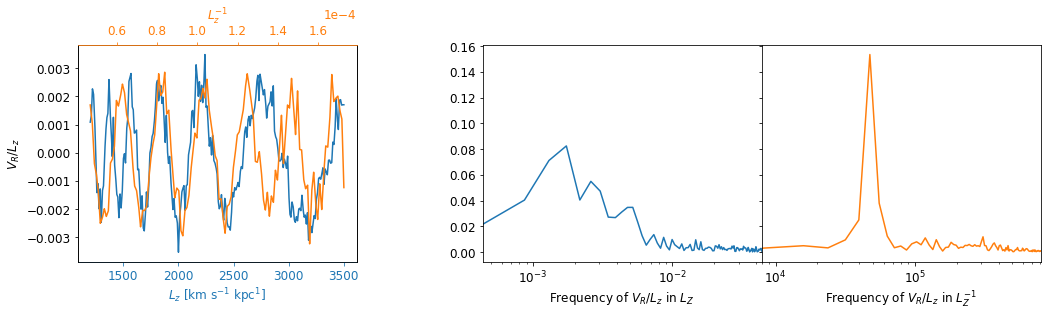

In [4]:
TIME = 2.0
XMIN=1200
XMAX=3500
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_model('Dhot_log', TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2)
DATA = False

fig = plt.figure(figsize=(15,4))
subfigs = fig.subfigures(1, 2, wspace=0, width_ratios=(1,2))
ax = []
ax.append(subfigs[0].add_subplot(111))
gs = subfigs[1].add_gridspec(1,2, hspace=0., wspace=0.)
ax.extend(gs.subplots(sharey=True))
#fig, axs = plt.subplots(1,4,figsize=(15,4))
#gs = axs[1:3].get_gridspec()
#for ax in axs[1:3]:
#    ax.remove()
#ax = axs[0] + gs.subplots(sharey=True)

nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
N = 100000
#f = interpolate.interp1d(nx, ny, kind='linear')
#xpol = np.linspace(nx[0], nx[-1], N)
#ypol = f(xpol)
#for i in range(3):
#    ax[i][0].hist2d(Lz[abs(VR)<40], VR[abs(VR)<40], bins=100);
#    ax[i][0].set_aspect('auto')
#    ax[i][0].set_xlabel(r'$L_Z$  [km s$^{-1}$ kpc$^{1}$]')
#    ax[i][0].set_ylabel(r'$V_R$ [km s$^{-1}$] ')

nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
N = 100000
P = 1
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)
#ax_right = ax[0][0].twinx()
#ax_right.plot(xpol, ypol, c='white')
#ax_right.set_ylabel('$L_z/V_R$')
ax[0].plot(xpol, ypol, c='C0')
ax[0].set_aspect('auto')
ax[0].spines['bottom'].set_color('C0')
ax[0].tick_params(axis='x', colors='C0')
ax[0].set_xlabel(r'$L_z$ [km s$^{-1}$ kpc$^{1}$]')
ax[0].xaxis.label.set_color('C0')
ax[0].set_ylabel(r'$V_R/L_z$')

ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol)
xf = fftfreq(N)
yf = yf[xf>0]
xf = xf[xf>0]

xfr = ((nx[-1]-nx[0]) / abs(xf * N))
print(1/xfr[np.argmax(np.abs(yf))])
ax[1].plot(1/xfr, np.abs(yf)/np.sum(np.abs(yf)), color='C0')
ax[1].set_xlim(1/max(xfr), 1/xfr[100])
ax[1].set_xscale('log')
#ax[1].xaxis.set_major_formatter(ticker.ScalarFormatter())
ax[1].set_aspect('auto')
ax[1].set_xlabel('Frequency of $V_R/L_z$ in $L_Z$')

n = -0.1
nx, ny = smooth_bins(Lz**((n-1)/(n+1)), VR/Lz, np.min(Lz**((n-1)/(n+1))), np.max(Lz**((n-1)/(n+1))), 1e-6)
N = 100000
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)
#ax_right = ax[2][0].twiny()
#ax_right.set_xlabel('$L_z^{-1}$')
#ax_right = ax_right.twinx()
#ax_right.plot(xpol, ypol, c='white')
#ax_right.set_ylabel('$L_z/V_R$')
axb = ax[0].twiny()
axb.plot(xpol, ypol, c='C1')
#axb.spines['top'].set_position(('outward', 40))
axb.spines['top'].set_color('C1')
axb.tick_params(axis='x', colors='C1')
axb.set_xlabel(r'$L_z^{-1}$')
axb.xaxis.label.set_color('C1')
plt.ticklabel_format(style='sci', axis='x', scilimits=(1e-3,1e4))

ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol)
xf = fftfreq(N)
yf = yf[xf>0]
xf = xf[xf>0]

xfr = ((nx[-1]-nx[0]) / abs(xf * N))
ax[2].plot(1/xfr, np.abs(yf)/np.sum(np.abs(yf)), color='C1')
print(1/xfr[np.argmax(np.abs(yf))])
ax[2].set_xlim(1/max(xfr), 1/xfr[100])
ax[2].set_xscale('log')
#ax[2].xaxis.set_major_formatter(ticker.ScalarFormatter())
ax[2].set_aspect('auto')
ax[2].set_xlabel('Frequency of $V_R/L_z$ in $L_Z^{-1}$')

#for i in range(1,4):
#    ax[i].set_ylim(0,0.175)

namef='plots/fourier_procedure'+'.png'
plt.savefig(namef, bbox_inches='tight')

Dhot_log
Dhotn10_pn10
Dhotn_10_pn_10
Dhot_log_2perturb


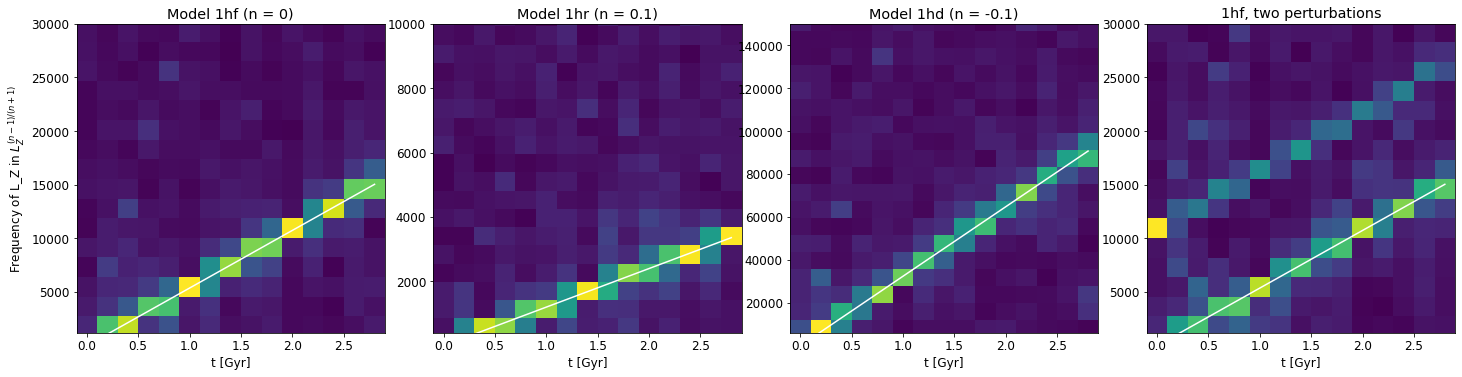

In [321]:

#N = 100000

#f = interpolate.interp1d(Lz, AR, kind='linear')
#xpol = np.linspace(1200, 3600, N)
#ypol = f(xpol)
#plt.plot(xpol, ypol, c='white')


eps = 0.00001
times = np.arange(eps, 3.0+eps, 0.2)
vtimes = list(times)

fig, ax = plt.subplots(1,4,figsize=(20,5))
fig.tight_layout()
#fig = plt.figure(constrained_layout=False,figsize=(ncols*2.45,nrows*2.5))
#gs = fig.add_gridspec(nrows,ncols, hspace=0., wspace=0.)
#ax = gs.subplots(sharex=True,sharey=True)

ns = [0,0.1,-0.1,0]
ylims=[30000,10000,150000,30000]
model_labels = ['Model 1hf (n = 0)', 'Model 1hr (n = 0.1)', 'Model 1hd (n = -0.1)', '1hf, two perturbations']
for model_i, model in enumerate(['Dhot_log', 'Dhotn10_pn10', 'Dhotn_10_pn_10', 'Dhot_log_2perturb']):
    print(model)
    fourier = []
    freqs = []
    freqs2 = []
    for time in times:
        XMIN=1200
        XMAX=3500
        BINSIZE = 10
        x,y,VR,Vphi,R,Lz,phi=l.load_model(model, time, xmin=XMIN, xmax=XMAX, phi_range=0.2)
        DATA = False

        n = ns[model_i]
        nx, ny = smooth_bins(Lz**((n-1)/(n+1)), VR/Lz, np.min(Lz**((n-1)/(n+1))), np.max(Lz**((n-1)/(n+1))), 1e-6)
        N = 100000
        f = interpolate.interp1d(nx, ny, kind='linear')
        xpol = np.linspace(nx[0], nx[-1], N)
        ypol = f(xpol)
        xpol = xpol[~np.isnan(ypol)]
        ypol = ypol[~np.isnan(ypol)]
        N = len(ypol)

        ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
        yf = fft(ypol)
        xf = fftfreq(N)
        yf = yf[xf>0]
        xf = xf[xf>0]
        xfr = ((nx[-1]-nx[0]) / abs(xf * N))
        fourier.append(yf)

        CUT = 4
        relxfr = xfr[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT]
        relyf = yf[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT]
        freq = sum(relxfr*abs(relyf))/sum(abs(relyf))
        if time > 2 and 1/freq < 1:  # Outliers (wrong peak detected)
            vtimes.remove(time)
            continue
        freqs.append(freq)

        CUT = 4
        yfb = yf.copy()
        yfb[max(0,abs(yfb).argmax()-CUT):abs(yfb).argmax()+CUT+1] = 0
        relxfr = xfr[max(0,abs(yfb).argmax()-CUT):abs(yfb).argmax()+CUT+1]
        relyf = yfb[max(0,abs(yfb).argmax()-CUT):abs(yfb).argmax()+CUT+1]
        freq = sum(relxfr*abs(relyf))/sum(abs(relyf))
        freqs2.append(freq)

    fourier = np.abs(np.array(fourier))
    xfr = xfr[:100]
    fourier = fourier[:,:100]

    #Z = fourier.T/np.max(fourier, axis=1)
    Z = fourier.T/np.sum(fourier, axis=1)
    #f = [interpolate.interp1d(xfr,fou,kind='linear') for fou in fourier]
    #y_coords = np.linspace(min(xfr),max(xfr),500)
    #Z = [fi(y_coords) for fi in f]
    #Z = np.array(Z).T
    #plt.imshow(fourier,extent=[min(times),max(times),0,max(times)],origin="lower")
    #f = interpolate.interp2d(times,xfr,fourier,kind="linear")
    #x_coords = times
    #y_coords = np.linspace(min(xfr),max(xfr),200)
    #Z = f(x_coords,y_coords)
    #Z = Z/Z.sum(axis=1,keepdims=1)
    #plt.imshow((Z/np.max(Z)),extent=[min(times),max(times),min(xfr),max(xfr)],origin="lower",aspect="auto",cmap='viridis')
    #plt.pcolormesh(times, xfr, fourier.T, shading='gouraud', cmap='viridis')
    #plt.pcolormesh(times, 1/xfr, fourier.T, cmap='viridis')
    ax[model_i].pcolormesh(times, 1/xfr, Z, cmap='viridis')
    ax[model_i].set_xlabel('t [Gyr]')
    ax[model_i].set_ylim(ylims[model_i]/25,ylims[model_i])
    ax[model_i].set_title(model_labels[model_i])
    ax[0].set_ylabel(r'Frequency of L_Z in $L_Z^{(n-1)/(n+1)}$')
    #if model_i > 0:
    #    ax[model_i].yaxis.set_ticklabels([])
    
    #def freqcurve(t, n):
    #    Vc = 240
    #    R0 = 8
    #    ct = (Vc / R0**n) ** (-2/(1+n))
    #    return 2 * (1-0.5*np.sqrt(2*(n+1))) / (2*np.pi) / ct * t
    
    #def freqcurve(t, n):
    #    Vc = 240
    #    R0 = 8
    #    ct = (Vc / R0**n) ** (2/(1-n)) * (1-0.5*np.sqrt(2*n+2)) ** ((1+n)/(1-n))
    #    phispace = (((10.5*np.pi)**((1+n)/(1-n)) - (0.5*np.pi)**((1+n)/(1-n)))) / 5
    #    return 2 * ct * t**((1+n)/(1-n)) / phispace
    
    def freqcurve(t, n):
        Vc = 240
        R0 = 8
        #return 1/((Vc/R0**n)**(-2/(1+n)) * (1-0.5*np.sqrt(2*n+2)) / t * (2*np.pi))
        ct = (Vc / R0**n) ** (2/(1+n)) * (1-0.5*np.sqrt(2*n+2)) / np.pi
        return ct * t
    
    #def freqcurve2(t, n):
    #    Vc = 240
    #    R0 = 8
    #    ct = (Vc / R0**n) ** (2/(1-n)) * (1-0.5*np.sqrt(2*n+2)) ** ((1+n)/(1-n))
    #    phispace = np.pi
    #    return 2 * ct * t / phispace

    ax[model_i].plot(times, freqcurve(times, n=ns[model_i]), c='w')
    #ax[model_i].plot(times, freqcurve2(times, n=ns[model_i]), c='w', ls='--')

    #plt.plot(vtimes, np.array(freqs), color='w')

    #fit = np.polyfit(vtimes, 1/np.array(freqs), 1)
    #pol = np.poly1d(fit)
    ##plt.plot(times[1/pol(times) < max(y_coords)], 1/pol(times)[1/pol(times)<max(y_coords)], c='w')
    #ax[model_i].plot(times, pol(times), c='w')

    #if model == 'Dhot_log_2perturb':
    #    fit = np.polyfit(vtimes, 1/np.array(freqs2), 1)
    #    pol = np.poly1d(fit)
    #    #plt.plot(times[1/pol(times) < max(y_coords)], 1/pol(times)[1/pol(times)<max(y_coords)], c='w', ls='--')
    #    ax[model_i].plot(times, pol(times), c='w', ls='--')


namef='plots/fourier_time'+'_simplemodels'+'.png'
plt.savefig(namef, bbox_inches='tight')



16110.283474572047
3594.9193682271375
97151.44908186297


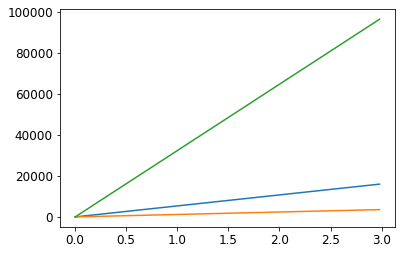

In [314]:
times = np.arange(eps, 3.0+eps, 0.02)
def freqcurve(t, n):
    Vc = 240
    R0 = 8
    #return 1/((Vc/R0**n)**(-2/(1+n)) * (1-0.5*np.sqrt(2*n+2)) / t * (2*np.pi))
    ct = (Vc / R0**n) ** (2/(1+n)) * (1-0.5*np.sqrt(2*n+2)) / np.pi
    return ct * t

def freqcurve_ap(t, n):
    Vc = 240
    R0 = 8
    ct = (Vc / R0**n) ** (2/(1-n)) * (1-0.5*np.sqrt(2*n+2)) ** ((1+n)/(1-n))
    phispace = (((10.5*np.pi)**((1+n)/(1-n)) - (0.5*np.pi)**((1+n)/(1-n)))) / 5
    return 2 * ct * t / phispace

#def freqcurve(t, n):
#    Vc = 240
#    R0 = 8
#    ct = (Vc / R0**n) ** (2/(1-n)) * (1-0.5*np.sqrt(2*n+2))
#    phispace = (2*np.pi)**((1+n)/(1-n))
#    return 2 * ct * t / phispace

n = 0
plt.plot(times, freqcurve(times, n))
print(freqcurve(3,n))
n = 0.1
plt.plot(times, freqcurve(times, n))
print(freqcurve(3,n))
n = -0.1
plt.plot(times, freqcurve(times, n))
print(freqcurve(3,n))


In [322]:
#N = 100000

#f = interpolate.interp1d(Lz, AR, kind='linear')
#xpol = np.linspace(1200, 3600, N)
#ypol = f(xpol)
#plt.plot(xpol, ypol, c='white')

eps = 0.00001
#times = np.arange(eps, 3.0+eps, 0.02)
times = np.arange(0.1, 7.0, 0.1)
vtimes = list(times)

binsizes = [10, 1e-6]
n = (-0.1-1)/(-0.1+1)
for tfi, tf in enumerate([lambda x: x, lambda x: x**n]):
    fourier = []
    freqs = []
    freqs2 = []
    for time in times:
        print(time)

        #XMIN=1200
        #XMAX=3500
        #BINSIZE = 10
        #x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, time, xmin=XMIN, xmax=XMAX, phi_range=0.2)

        XMIN=1000
        XMAX=3500
        BINSIZE = 50
        x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', time, xmin=XMIN, xmax=XMAX, phi_range=0.2, maxvr=100)
        DATA = False

        nx, ny = smooth_bins(tf(Lz), VR/Lz, np.min(tf(Lz)), np.max(tf(Lz)), binsizes[tfi])
        N = 100000
        f = interpolate.interp1d(nx, ny, kind='linear')
        xpol = np.linspace(nx[0], nx[-1], N)
        ypol = f(xpol)
        xpol = xpol[~np.isnan(ypol)]
        ypol = ypol[~np.isnan(ypol)]
        N = len(ypol)

        ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
        yf = fft(ypol)
        xf = fftfreq(N)
        yf = yf[xf>0]
        xf = xf[xf>0]
        xfr = ((nx[-1]-nx[0]) / abs(xf * N))
        fourier.append(yf)

        CUT = 4
        relxfr = xfr[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT]
        relyf = yf[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT]
        freq = sum(relxfr*abs(relyf))/sum(abs(relyf))
        if time > 2 and 1/freq < 1:  # Outliers (wrong peak detected)
            vtimes.remove(time)
            continue
        freqs.append(freq)

        CUT = 4
        yfb = yf.copy()
        yfb[max(0,abs(yfb).argmax()-CUT):abs(yfb).argmax()+CUT+1] = 0
        relxfr = xfr[max(0,abs(yfb).argmax()-CUT):abs(yfb).argmax()+CUT+1]
        relyf = yfb[max(0,abs(yfb).argmax()-CUT):abs(yfb).argmax()+CUT+1]
        freq = sum(relxfr*abs(relyf))/sum(abs(relyf))
        freqs2.append(freq)

    np.save(f'fourier_time_mwsgr_10_35_{tfi}.npy', fourier)
    np.save(f'xfr_time_mwsgr_10_35_{tfi}.npy', xfr)


0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3000000000000003
1.4000000000000001
1.5000000000000002
1.6
1.7000000000000002
1.8000000000000003
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5000000000000004
2.6
2.7
2.8000000000000003
2.9000000000000004
3.0000000000000004
3.1
3.2
3.3000000000000003
3.4000000000000004
3.5000000000000004
3.6
3.7
3.8000000000000003
3.9000000000000004
4.0
4.1
4.2
4.3
4.3999999999999995
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9


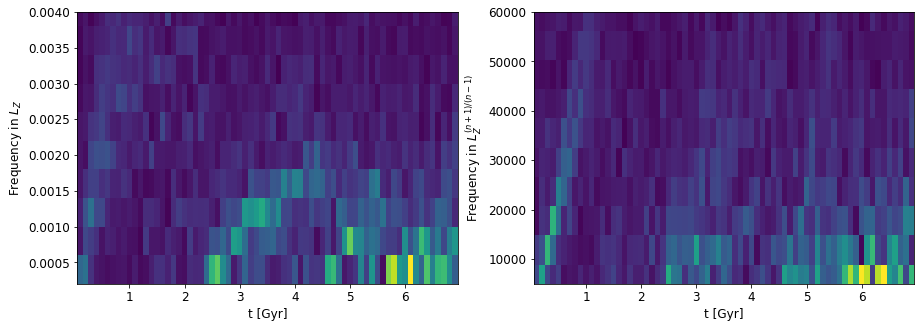

In [332]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
times = np.arange(0.1, 7.0, 0.1)
ylims = [[0.00020,0.004], [5000,60000]]
desc = ["L_Z", "L_Z^{(n+1)/(n-1)}"]
for tfi in range(2):
    fourier = np.load(f'fourier_time_mwsgr_10_35_{tfi}.npy')
    xfr = np.load(f'xfr_time_mwsgr_10_35_{tfi}.npy')
    fourier = np.abs(np.array(fourier))
    xfr = xfr[:100]
    fourier = fourier[:,:100]

    #Z = fourier.T/np.max(fourier, axis=1)
    Z = fourier.T/np.sum(fourier, axis=1)
    #f = [interpolate.interp1d(xfr,fou,kind='linear') for fou in fourier]
    #y_coords = np.linspace(min(xfr),max(xfr),500)
    #Z = [fi(y_coords) for fi in f]
    #Z = np.array(Z).T
    #plt.imshow(fourier,extent=[min(times),max(times),0,max(times)],origin="lower")
    #f = interpolate.interp2d(times,xfr,fourier,kind="linear")
    #x_coords = times
    #y_coords = np.linspace(min(xfr),max(xfr),200)
    #Z = f(x_coords,y_coords)
    #Z = Z/Z.sum(axis=1,keepdims=1)
    #plt.imshow((Z/np.max(Z)),extent=[min(times),max(times),min(xfr),max(xfr)],origin="lower",aspect="auto",cmap='viridis')
    #plt.pcolormesh(times, xfr, fourier.T, shading='gouraud', cmap='viridis')
    #plt.pcolormesh(times, 1/xfr, fourier.T, cmap='viridis')
    ax[tfi].pcolormesh(times, 1/xfr, Z, cmap='viridis')
    ax[tfi].set_xlabel('t [Gyr]')
    ax[tfi].set_ylabel(fr'Frequency in ${desc[tfi]}$')
    ax[tfi].set_ylim(*ylims[tfi])


    #plt.plot(vtimes, np.array(freqs), color='w')

    #fit = np.polyfit(vtimes, 1/np.array(freqs), 1)
    #pol = np.poly1d(fit)
    ##plt.plot(times[1/pol(times) < max(y_coords)], 1/pol(times)[1/pol(times)<max(y_coords)], c='w')
    #ax[model_i].plot(times, pol(times), c='w')
#
    #if model == 'Dhot_log_2perturb':
    #    fit = np.polyfit(vtimes, 1/np.array(freqs2), 1)
    #    pol = np.poly1d(fit)
    #    #plt.plot(times[1/pol(times) < max(y_coords)], 1/pol(times)[1/pol(times)<max(y_coords)], c='w', ls='--')
    #    ax[model_i].plot(times, pol(times), c='w', ls='--')


namef='plots/fourier_time'+'_mwsgr'+'.png'
plt.savefig(namef, bbox_inches='tight')

/home/hpc/anaconda3/lib/python3.9/site-packages/astropy/table/table.py:3488: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other

0.0008888888888888889
[0.00088889 0.00133333 0.00177778 0.00222222 0.00266667 0.00311111
 0.00355556 0.004      0.00444444 0.00488889 0.00533333 0.00577778
 0.00622222 0.00666667 0.00711111 0.00755556 0.008      0.00844444
 0.00888889]
6097.560975609773
[ 12195.12195122  18292.68292683  24390.24390244  30487.80487805
  36585.36585366  42682.92682927  48780.48780488  54878.04878049
  60975.6097561   67073.17073171  73170.73170732  79268.29268293
  85365.85365854  91463.41463415  97560.97560976 103658.53658537
 109756.09756098 115853.65853659 121951.2195122 ]


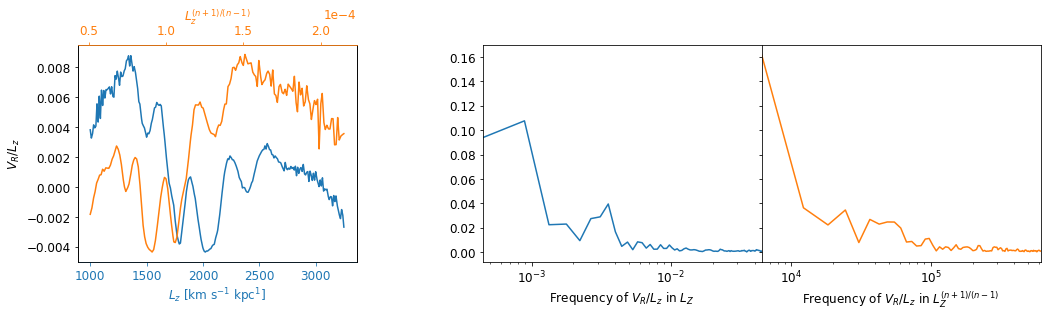

In [334]:
XMIN=1000
XMAX=3250
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2)
DATA = True

fig = plt.figure(figsize=(15,4))
subfigs = fig.subfigures(1, 2, wspace=0, width_ratios=(1,2))
ax = []
ax.append(subfigs[0].add_subplot(111))
gs = subfigs[1].add_gridspec(1,2, hspace=0., wspace=0.)
ax.extend(gs.subplots(sharey=True))
#fig, axs = plt.subplots(1,4,figsize=(15,4))
#gs = axs[1:3].get_gridspec()
#for ax in axs[1:3]:
#    ax.remove()
#ax = axs[0] + gs.subplots(sharey=True)

nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
N = 100000
#f = interpolate.interp1d(nx, ny, kind='linear')
#xpol = np.linspace(nx[0], nx[-1], N)
#ypol = f(xpol)
#for i in range(3):
#    ax[i][0].hist2d(Lz[abs(VR)<40], VR[abs(VR)<40], bins=100);
#    ax[i][0].set_aspect('auto')
#    ax[i][0].set_xlabel(r'$L_Z$  [km s$^{-1}$ kpc$^{1}$]')
#    ax[i][0].set_ylabel(r'$V_R$ [km s$^{-1}$] ')

nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
N = 100000
P = 1
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)
#ax_right = ax[0][0].twinx()
#ax_right.plot(xpol, ypol, c='white')
#ax_right.set_ylabel('$L_z/V_R$')
ax[0].plot(xpol, ypol, c='C0')
ax[0].set_aspect('auto')
ax[0].spines['bottom'].set_color('C0')
ax[0].tick_params(axis='x', colors='C0')
ax[0].set_xlabel(r'$L_z$ [km s$^{-1}$ kpc$^{1}$]')
ax[0].xaxis.label.set_color('C0')
ax[0].set_ylabel(r'$V_R/L_z$')

ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol)
xf = fftfreq(N)
yf = yf[xf>0]
xf = xf[xf>0]

xfr = ((nx[-1]-nx[0]) / abs(xf * N))
print(1/xfr[np.argmax(np.abs(yf))])
ax[1].plot(1/xfr, np.abs(yf)/np.sum(np.abs(yf)), color='C0')
ax[1].set_xlim(1/max(xfr), 1/xfr[100])
print(1/xfr[1:20])
ax[1].set_xscale('log')
#ax[1].xaxis.set_major_formatter(ticker.ScalarFormatter())
ax[1].set_aspect('auto')
ax[1].set_xlabel('Frequency of $V_R/L_z$ in $L_Z$')

n = -0.1
nx, ny = smooth_bins(Lz**((n-1)/(n+1)), VR/Lz, np.min(Lz**((n-1)/(n+1))), np.max(Lz**((n-1)/(n+1))), 1e-6)
N = 100000
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)
#ax_right = ax[2][0].twiny()
#ax_right.set_xlabel('$L_z^{-1}$')
#ax_right = ax_right.twinx()
#ax_right.plot(xpol, ypol, c='white')
#ax_right.set_ylabel('$L_z/V_R$')
axb = ax[0].twiny()
axb.plot(xpol, ypol, c='C1')
#axb.spines['top'].set_position(('outward', 40))
axb.spines['top'].set_color('C1')
axb.tick_params(axis='x', colors='C1')
axb.set_xlabel(r'$L_z^{(n+1)/(n-1)}$')
axb.xaxis.label.set_color('C1')
plt.ticklabel_format(style='sci', axis='x', scilimits=(1e-3,1e4))

ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol)
xf = fftfreq(N)
yf = yf[xf>0]
xf = xf[xf>0]

xfr = ((nx[-1]-nx[0]) / abs(xf * N))
ax[2].plot(1/xfr, np.abs(yf)/np.sum(np.abs(yf)), color='C1')
print(1/xfr[np.argmax(np.abs(yf))])
ax[2].set_xlim(1/max(xfr), 1/xfr[100])
print(1/xfr[1:20])
ax[2].set_xscale('log')
#ax[2].xaxis.set_major_formatter(ticker.ScalarFormatter())
ax[2].set_aspect('auto')
ax[2].set_xlabel(r'Frequency of $V_R/L_z$ in $L_Z^{(n+1)/(n-1)}$')

#for i in range(1,4):
#    ax[i].set_ylim(0,0.175)

namef='plots/fourier_data'+'.png'
plt.savefig(namef, bbox_inches='tight')